In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Truncated gaussian function definition
import torch
import math

def truncated_normal(
    x: torch.Tensor,
    mean: torch.Tensor,
    std: torch.Tensor,
    a: torch.Tensor,
    b: torch.Tensor
) -> torch.Tensor:
    """
    Computes the probability density function of a truncated normal distribution.
    
    Args:
        x (torch.Tensor): Points at which to evaluate the PDF.
        mean (torch.Tensor): Mean of the normal distribution.
        std (torch.Tensor): Standard deviation of the normal distribution.
        a (torch.Tensor): Lower truncation bound.
        b (torch.Tensor): Upper truncation bound.
        
    Returns:
        torch.Tensor: PDF values at x.
    """
    # Standardize bounds and input
    alpha = (a - mean) / std
    beta = (b - mean) / std
    z = (x - mean) / std
    
    # Standard normal PDF: φ(z) = (1/√(2π)) * exp(-z²/2)
    sqrt_2pi = math.sqrt(2 * math.pi)
    phi_z = torch.exp(-0.5 * z**2) / sqrt_2pi
    
    # Standard normal CDF: Φ(z) = 0.5 * (1 + erf(z/√2))
    sqrt_2 = math.sqrt(2)
    Phi_alpha = 0.5 * (1 + torch.erf(alpha / sqrt_2))
    Phi_beta = 0.5 * (1 + torch.erf(beta / sqrt_2))
    
    # Normalization constant (probability mass in [a,b])
    Z = Phi_beta - Phi_alpha
    
    # Handle edge case where Z approaches 0
    Z = torch.clamp(Z, min=1e-8)
    
    # Calculate PDF: φ((x-μ)/σ) / (σ * Z)
    pdf_unnormalized = phi_z / std
    pdf = pdf_unnormalized / Z
    
    # Set PDF to 0 outside truncation bounds
    mask = (x >= a) & (x <= b)
    pdf = torch.where(mask, pdf, torch.zeros_like(pdf))
    
    return pdf


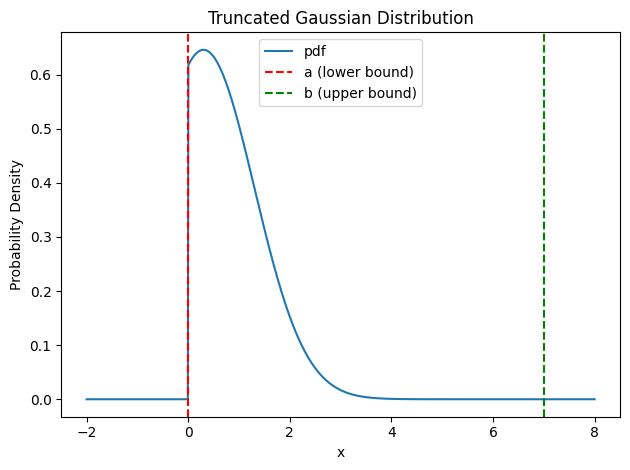

In [3]:
num_samples = 1000
mu = torch.ones(num_samples) * 0.3
sigma = torch.ones(num_samples) * 1.0
a = torch.ones(num_samples) * 0.
b = torch.ones(num_samples) * 7.0

x = torch.linspace(-2, 8, num_samples)
y = truncated_normal(x, mu, sigma, a, b)

plt.plot(x.numpy(), y.numpy(), label='pdf')
plt.title('Truncated Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.axvline(a[0].item(), color='red', linestyle='--', label='a (lower bound)')
plt.axvline(b[0].item(), color='green', linestyle='--', label='b (upper bound)')    
plt.legend()
plt.tight_layout()

### 1. Rejection Sampling

In [8]:
def sample_truncated_normal(
    mean: torch.Tensor,
    std: torch.Tensor,
    a: torch.Tensor,
    b: torch.Tensor
) -> torch.Tensor:
    """Vectorized truncated normal sampling using inverse CDF.
    
    Args:
        mean (torch.Tensor): Mean of the normal distribution.
        std (torch.Tensor): Standard deviation of the normal distribution.
        a (torch.Tensor): Lower bound for truncation.
        b (torch.Tensor): Upper bound for truncation.
        
    Returns:
        torch.Tensor: Samples from the truncated normal distribution.
    """
    # eps value to avoid numerical issues
    eps = 1e-7
    # Compute standardized bounds
    alpha = (a - mean) / std
    beta = (b - mean) / std
    
    # Compute CDF values
    sqrt_2 = math.sqrt(2.0)
    alpha_cdf = 0.5 * (1 + torch.erf(alpha / sqrt_2))
    beta_cdf = 0.5 * (1 + torch.erf(beta / sqrt_2))
    
    # Sample uniform in transformed space
    u = torch.rand_like(mean)
    p = alpha_cdf + (beta_cdf - alpha_cdf) * u
    
    # Apply inverse normal CDF
    x = sqrt_2 * torch.erfinv(torch.clamp(2 * p - 1, min=-1 + eps, max=1 - eps))
    
    # Transform to original scale
    samples = mean + std * x
    
    # Ensure bounds (extra safety)
    return torch.clamp(samples, min=a, max=b)

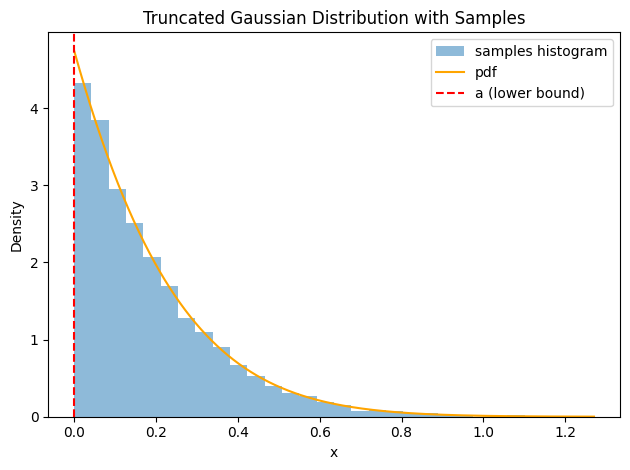

In [21]:
import torch
import math

num_samples = 10000
mu = torch.ones(num_samples) * -1.0
sigma = torch.ones(num_samples) * 0.5
a = torch.ones(num_samples) * 0.
b = torch.ones(num_samples) * torch.inf

samples = sample_truncated_normal(mu, sigma, a, b)

x = torch.linspace(samples.min(), samples.max(), num_samples)
y = truncated_normal(x, mu, sigma, a, b)

plt.hist(samples.cpu().numpy(), bins=30, density=True, alpha=0.5, label='samples histogram')
plt.plot(x.numpy(), y.numpy(), label='pdf', color='orange')
plt.title('Truncated Gaussian Distribution with Samples')
plt.xlabel('x')
plt.ylabel('Density')
plt.axvline(a[0].item(), color='red', linestyle='--', label='a (lower bound)')
plt.legend()
plt.tight_layout()